In [1]:
from neurovelo.train import Trainer
from neurovelo.utils import ModelAnalyzer,latent_data
import scvelo as scv
import scanpy as sc
from sklearn import preprocessing
import glob

```adata``` object is the multiomics data is the one in [this paper](https://www.biorxiv.org/content/10.1101/2023.11.15.567140v1). 

```trained_models``` has a torch saved trained models using different initializations.

In [2]:
adata = sc.read_h5ad('/scratch/ikouadri/moved_from_infec_many_node/multiomic_data.h5ad')
trained_models = glob.glob('/scratch/ikouadri/trained_model/pca/multiomics/*5k*')

Do all the preprocessing before running the analysis.

<div class="alert alert-block alert-danger">
<b>Important:</b> Preprocessing steps down here should be identical to the one used to train the models.
</div>

Abundance of ['unspliced', 'spliced', 'ambiguous']: [0.49 0.42 0.09]


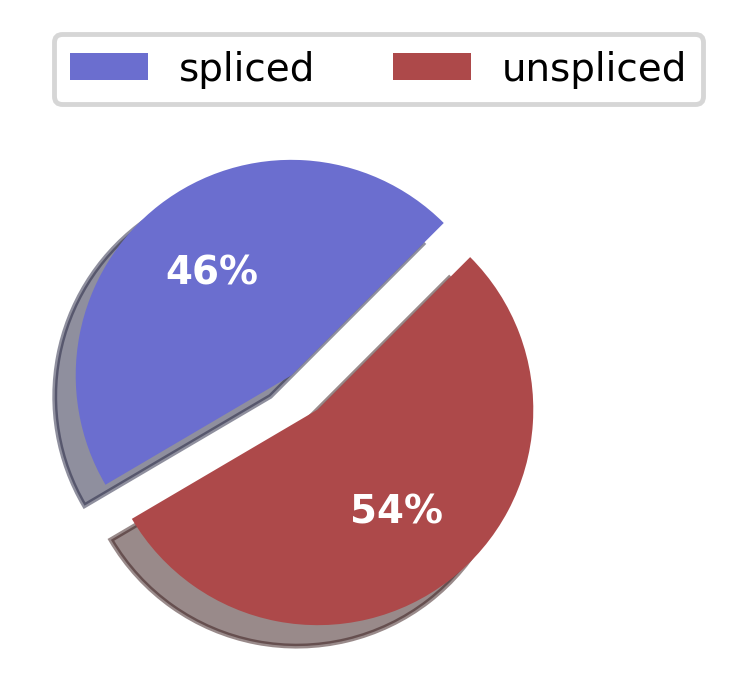

Normalized count data: X, spliced, unspliced.
Extracted 7000 highly variable genes.
Logarithmized X.


In [3]:
scv.pp.remove_duplicate_cells(adata)
scv.utils.show_proportions(adata)
scv.pl.proportions(adata, dpi=350)
scv.pp.filter_and_normalize(adata, n_top_genes=7000)
sc.pp.log1p(adata, layer='spliced')
sc.pp.log1p(adata, layer='unspliced')

#All the models were initialized with PCA, so we are centring the reads as well.
adata.layers['spliced'] = adata.layers['spliced'] - (adata.layers['spliced'].mean(0))
adata.layers['unspliced'] = adata.layers['unspliced'] - (adata.layers['unspliced'].mean(0))

In [4]:
le = preprocessing.LabelEncoder()
adata.obs['treatment'] = le.fit_transform(adata.obs['sample'])
adata.obs['treatment'], adata.obs['sample'] = adata.obs['sample'] ,adata.obs['treatment']
#This is just to encoder labels to number between 0 and n_samples-1

<div class="alert alert-block alert-info">
<b>In case you have categorical samples:</b> always encode them with a value between 0 and n_samples-1
</div>

In [5]:
adata.obs

sample  initial_size_unspliced  \
CellID                                                                 
multiome_sample_9:AAACATGCATAGCGAGx        0                    5905   
multiome_sample_9:AAAGGCTCAACACCTAx        0                    8022   
multiome_sample_9:AAAGCGGGTGCGCATGx        0                    3789   
multiome_sample_9:AAAGGAGCACTAGGTCx        0                   12365   
multiome_sample_9:AAAGCAAGTCCGGTTCx        0                    3922   
...                                      ...                     ...   
multiome_sample_17:TTTGGTGCAGCCAGTTx       1                   12519   
multiome_sample_17:TTTGCGACAGGCTTGTx       1                    2731   
multiome_sample_17:TTTGCGACAAGATTCTx       1                     232   
multiome_sample_17:TTTGTGGCATAATCCGx       1                   12987   
multiome_sample_17:TTTGCGACAGATAGACx       1                     541   

                                      initial_size_spliced  initial_size  \
CellID                                                                     
multiome_sample_9:AAACATGCATAGCGAGx                   5232        5232.0   
multiome_sample_9:AAAGGCTCAACACCTAx                   6541        6541.0   
multiome_sample_9:AAAGCGGGTGCGCATGx                   3850        3850.0   
multiome_sample_9:AAAGGAGCACTAGGTCx                  12563       12563.0   
multiome_sample_9:AAAGCAAGTCCGGTTCx                   3797        3797.0   
...                                                    ...           ...   
multiome_sample_17:TTTGGTGCAGCCAGTTx                  9676        9676.0   
multiome_sample_17:TTTGCGACAGGCTTGTx                  1888        1888.0   
multiome_sample_17:TTTGCGACAAGATTCTx                   481         481.0   
multiome_sample_17:TTTGTGGCATAATCCGx                  9323        9323.0   
multiome_sample_17:TTTGCGACAGATAGACx                   511         511.0   

                                         n_counts       treatment  
CellID                                                             
multiome_sample_9:AAACATGCATAGCGAGx   6345.000000             AZD  
multiome_sample_9:AAAGGCTCAACACCTAx   6345.000488             AZD  
multiome_sample_9:AAAGCGGGTGCGCATGx   6345.000000             AZD  
multiome_sample_9:AAAGGAGCACTAGGTCx   6345.000000             AZD  
multiome_sample_9:AAAGCAAGTCCGGTTCx   6345.000488             AZD  
...                                           ...             ...  
multiome_sample_17:TTTGGTGCAGCCAGTTx  6345.000488  AZD_Trametinib  
multiome_sample_17:TTTGCGACAGGCTTGTx  6345.000000  AZD_Trametinib  
multiome_sample_17:TTTGCGACAAGATTCTx  6345.000488  AZD_Trametinib  
multiome_sample_17:TTTGTGGCATAATCCGx  6345.000488  AZD_Trametinib  
multiome_sample_17:TTTGCGACAGATAGACx  6345.000000  AZD_Trametinib  

[34523 rows x 6 columns]

<div class="alert alert-block alert-info">
<b>Notice:</b> Treatment and sample obs are the same. Treatment is kept to save the result analysis under the treatment name rather than an index. 
</div>

***To avoid any kind of bugs running the analysis. Assign you categorical sample to ```treatment``` obs in the anndata object***

In [6]:
latent_adata = latent_data(adata, trained_models[0], layer='spliced')
sc.pp.neighbors(latent_adata, use_rep='X_z', n_neighbors=20)
sc.tl.umap(latent_adata,  min_dist=0.1)

2023-11-21 10:59:33.242837: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-21 10:59:33.289209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-21 10:59:35.493387: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


computing velocity graph (using 1/112 cores)


  0%|          | 0/34523 [00:00<?, ?cells/s]

    finished (0:00:17) --> added 
    'spliced_velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:07) --> added
    'spliced_velocity_umap', embedded velocity vectors (adata.obsm)
saving figure to file ./figures/scvelo_velocity_on_multiomics_data.png


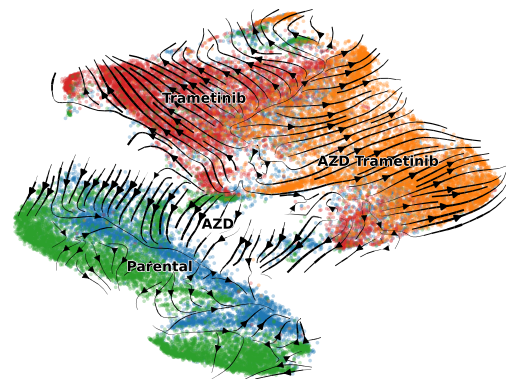

In [7]:
scv.tl.velocity_graph(latent_adata, vkey='spliced_velocity', xkey='spliced')
scv.tl.velocity_embedding(latent_adata, vkey='spliced_velocity', basis='umap')
scv.pl.velocity_embedding_stream(latent_adata,basis='umap',vkey='spliced_velocity', color='treatment',title='',save='velocity_on_multiomics_data.png')


Running the analysis is straight forward, just pass the processed ```adata``` object, the number of eigenvectors to look at ```n_vectors``` (They are ranked from top to bottom by eigenvalues), and the path of torch saved models ```trained_models```

The output ```gene_ranking_order``` is a dictionary with keys are different treatments and values are pandas DataFrames containing ranked genes in different eigenvectors (each column is an eigenvectors)

The second output ```gene_ranking_mean``` is the average rank of a gene. You can use this directly in ```gseapy.prerank``` to run gene set enrichment analysis

In [8]:
analyzer = ModelAnalyzer(data=adata, n_vectors=7, models_path=trained_models)
results = analyzer.models_output()
gene_ranking_order, gene_ranking_mean = analyzer.gene_ranking()

In [9]:
gene_ranking_order['AZD_Trametinib']

0           1           2           3           4           5  \
1         PARD3B       DACH1         LPP       NELL2      CSRNP3       DACH1   
2          DACH1      CSRNP3      PARD3B        TFF3       DACH1      PARD3B   
3          NELL2      PARD3B       NELL2       NDRG1       TRPM3      CSRNP3   
4         CSRNP3       NELL2       ATXN1       DACH1      PARD3B    PRICKLE2   
5         PDE11A       FREM2      CSRNP3       ITPR2      PDE11A       FREM2   
...          ...         ...         ...         ...         ...         ...   
6996       DDX53       LYVE1  AC026801.2  AC121338.1       LYVE1      RAB39B   
6997       LYVE1  AL121900.1  AC005253.1       LYVE1       DDX53  AL589642.2   
6998      RAB39B      IGSF22  AL589642.2       DDX53  AL136980.1       DDX53   
6999  AL589642.2  AL589642.2  AL136038.3  AL589642.2  AL589642.2       LYVE1   
7000  AC024560.1       DDX53       DDX53      IGSF22      RAB39B  AC018904.1   

               6  
1         CSRNP3  
2          DACH1  
3         PARD3B  
4          ITPR2  
5          NELL2  
...          ...  
6996       DDX53  
6997       LYVE1  
6998     TMEM266  
6999      RAB39B  
7000  AL589642.2  

[7000 rows x 7 columns]